In [1]:
from IPython import get_ipython
from scipy import signal
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt

In [10]:
class MomentMethodSolver():
    def __init__(self):
        self.beta_range = np.linspace(-12, 12, 25) * 3.14 / 180
        self.delta_range = np.linspace(-12, 12, 25) * 3.14 / 180
        self.velocity = 36

    def solve(self):
        fy = np.empty([len(self.beta_range), len(self.delta_range)])
        mz = np.empty([len(self.beta_range), len(self.delta_range)])
        initial_guess = (0, 0)
        
        for i, beta in enumerate(self.beta_range):
            for j, delta in enumerate(self.delta_range):
                # Use previous solution as a guess
                if j > 0: initial_guess = self._invertSolution(fy[i][j-1], mz[i][j-1])
                elif i > 0: initial_guess = self._invertSolution(fy[i-1][j], mz[i-1][j])
                else: initial_guess = (0, 0)

                result = self._solve(beta, delta, initial_guess)
                fy[i][j] = result[0]
                mz[i][j] = result[1]

        return (fy, mz)

    def _solve(self, beta, delta, initial_guess = (0, 0)):

        MAX_ITER = 100
        n = 0
        error = 9999
        tolerance = 0.1
        yaw_velocity = 0
        length_a = wheelbase * (1 - weight_dist)
        length_b = wheelbase * weight_dist

        front_force = initial_guess[0]
        rear_force = initial_guess[1]

        while (n < MAX_ITER and abs(error) > tolerance):
          # Yaw rate
          yaw_velocity = (front_force + rear_force) / (mass * velocity)
          error = front_force + rear_force

          # Slip Angles
          sa_front = beta - delta + yaw_velocity * length_a/ velocity
          sa_rear = beta - yaw_velocity * length_b / velocity

          # Front Tire
          front_FZ = 0.5 * 9.81 * mass * weight_dist
          front_force = calculate_lateral_force(front_FZ, sa_front, 0)

          # Rear Tire
          rear_FZ = 0.5 * 9.81 * mass * (1 - weight_dist)
          rear_force = calculate_lateral_force(rear_FZ, sa_rear, 0)


          error -= front_force + rear_force
          n += 1

        return (front_force + rear_force,
            front_force * length_a - rear_force * length_b)

    def _invertSolution(self, lateral_force, yaw_moment):
        length_a = wheelbase * (1 - weight_dist)
        length_b = wheelbase * weight_dist
        front_force = (1 / (length_a + length_b)) * (length_b * lateral_force + yaw_moment)
        rear_force  = (1 / (length_a + length_b)) * (length_a * lateral_force - yaw_moment)
        return (front_force, rear_force)

In [17]:
def calculate_lateral_force(Fz, SA, IA):

    a0 = 1.4
    a1 = 0
    a2 = 1100
    a3 = 1100
    a4 = 10
    a5 = 0
    a6 = 0
    a7 = -2
    a8 = 0
    a9 = 0
    a10 = 1
    a11 = 0
    a12 = 0
    a13 = 0
    a14 = 0
    a15 = 0
    a16 = 0
    a17 = 0

    
    
    C = a0
    D = Fz * (a1 * Fz + a2) * (1 - a15 * IA * IA)
    BCD = a3 * np.sin(np.arctan(Fz / a4) * 2) * (1 - a5 * np.abs(IA))
    B = BCD / (C * D)
    H = a8 * Fz + a9 + a10 * IA
    E = (a6 * Fz + a7) * (1 - (a16 * IA + a17) * np.sign(SA + H))
    V = a11 * Fz + a12 + (a13 * Fz + a14) * IA * Fz
    Bx1 = B * (SA + H)

    F = D * np.sin(C * np.arctan(Bx1 - E * (Bx1 - np.arctan(Bx1)))) + V

    return F*1000


Text(0, 0.5, 'Yaw Moment [Nm]')

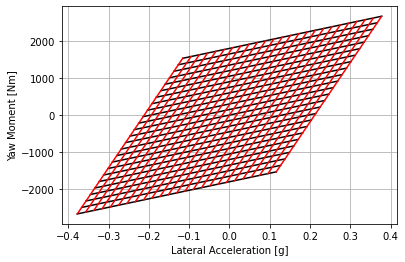

In [26]:
solver = MomentMethodSolver()

mass = 1250  # kg
wheelbase = 2.4  # m
weight_dist = 0.47  # ratio

solver.beta = np.linspace(-15, 16, 31) * 3.14 / 180
solver.delta = np.linspace(-15, 56, 31) * 3.14 / 180
solver.velocity = 70 / 3.6

force_moments = solver.solve()
lateral_accel = force_moments[0] / mass / 9.81
yaw_moment = force_moments[1]

plt.plot(lateral_accel[:][:], yaw_moment[:][:], color='black')
plt.plot(np.transpose(lateral_accel[:][:]), np.transpose(yaw_moment[:][:]), color='red')

plt.grid()
plt.xlabel("Lateral Acceleration [g]")
plt.ylabel("Yaw Moment [Nm]")